<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/bigearthnet%2Fvae/notebooks/Segmentation_DFC2020_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: ResNetUnet \\
Data: DFC2020 \\
Pretrained weights: dependent on pretext tasks



### Environment setup

In [ ]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@bigearthnet/vae

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision bigearthnet/vae) to /tmp/pip-install-2oexsecn/ssl-remote-sensing_96efe1a963834b9fb4d66f752ebc7048
  Running command git clone -q https://github.com/AlexanderLontke/ssl-remote-sensing.git /tmp/pip-install-2oexsecn/ssl-remote-sensing_96efe1a963834b9fb4d66f752ebc7048
  Running command git checkout -b bigearthnet/vae --track origin/bigearthnet/vae
  Switched to a new branch 'bigearthnet/vae'
  Branch 'bigearthnet/vae' set up to track remote branch 'bigearthnet/vae' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for ssl-remote-sensing: filename=ssl_remote_sensing-0.0.post1.dev210+gc5a7b4c-py3-none-any.whl size=50425 sha256=2a09bf89947e22780a95273d02d76ca3bd04f105e

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ssl_remote_sensing.data.dfc2020 import DFC2020
from ssl_remote_sensing.downstream_tasks.segmentation.utils import patch_first_conv, get_metrics, visualize_result
from ssl_remote_sensing.downstream_tasks.segmentation.training import train
from ssl_remote_sensing.downstream_tasks.segmentation.model import ResNetUNet
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility
from ssl_remote_sensing.constants import RANDOM_INITIALIZATION
from ssl_remote_sensing.pretext_tasks.utils import (
    load_encoder_checkpoint_from_pretext_model,
)

/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.8/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

In [ ]:
import rasterio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import torch 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from torchmetrics import JaccardIndex
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score
import gdown
import tarfile

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [ ]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
RANDOM_INITIALIZATION

'random'

In [ ]:
g_drive_path = "/content/drive/MyDrive/deep_learning_checkpoints"
check_point_paths = os.listdir(g_drive_path)
check_point_paths += [RANDOM_INITIALIZATION]
check_point_paths = [g_drive_path + "/" + x for x in check_point_paths]
check_point_paths

['/content/drive/MyDrive/deep_learning_checkpoints/vae_bigearthnet.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/bigan_encoder_allChannels_10_epochs.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCLR_BEN_ResNet18_adam_bs500-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/variational_autoencoder_eurosatRGB.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/SimCcLR_ResNet18_adam_bs2250-v1.ckpt',
 '/content/drive/MyDrive/deep_learning_checkpoints/random']

### Hyperparameter setup

In [ ]:
# Model Setup
class Hparams:
    def __init__(self):
        self.epochs = 10 # number of training epochs for pretext tasks
        self.seed = 1234  # randomness seed
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = False
        self.split = False
        self.frozen = True

In [ ]:
train_config = Hparams()

In [ ]:
reproducibility(train_config)

## Data

In [ ]:
dfc2020_path = '/content/drive/MyDrive/dfc2020/dfc_2020.tar.gz'

In [ ]:
with tarfile.open(dfc2020_path, mode="r") as tar:
    tar.extractall(path='/content/')

In [ ]:
from torch.utils.data import random_split

In [ ]:
dataset = DFC2020('/content/dfc_data', subset="test", use_s1=False, use_s2lr=True, use_s2hr=True,
                 use_s2mr=True, no_savanna=True)
trainset, valset = random_split(dataset, [4102, 1026])

[Load]: 100%|██████████| 5128/5128 [00:00<00:00, 405214.70it/s]

loaded 5128 samples from the dfc2020 subset test


id: ROIs0000_test_s2_0_p1150.tif 
 input shape: (12, 256, 256) 
 label shape: (256, 256) 



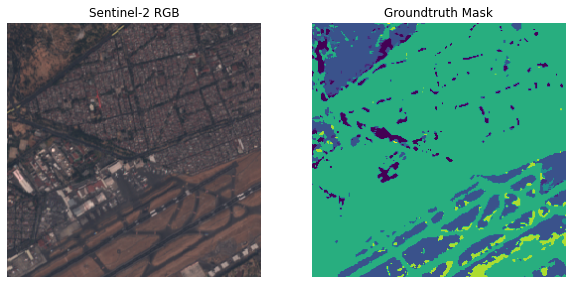

In [ ]:
dataset.visualize_observation(170)

In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)
val_loader = DataLoader(valset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=1,
                          pin_memory=True,
                          drop_last=False)

In [ ]:
next(iter(train_loader))["label"].shape

torch.Size([32, 256, 256])

## Segmentation Model

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


Validation Loss: 0.8440: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]

train_iou is 0.2909, val_iou is 0.3320
train_acc is 0.6721, val_acc is 0.7121



Validation Loss: 0.6320: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3664, val_iou is 0.3929
train_acc is 0.7474, val_acc is 0.7687


Validation Loss: 0.6021: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3882, val_iou is 0.4006
train_acc is 0.7633, val_acc is 0.7811


Validation Loss: 0.5175: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.4091, val_iou is 0.4350
train_acc is 0.7792, val_acc is 0.8110


Validation Loss: 0.5146: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.4243, val_iou is 0.4413
train_acc is 0.7914, val_acc is 0.8122


Validation Loss: 0.5131: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.4351, val_iou is 0.4489
train_acc is 0.8004, val_acc is 0.8126


Validation Loss: 0.5124: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]


Saving Model...
train_iou is 0.4444, val_iou is 0.4584
train_acc is 0.8065, val_acc is 0.8110


Validation Loss: 0.4955: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.4522, val_iou is 0.4587
train_acc is 0.8090, val_acc is 0.8187


Validation Loss: 0.4476: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.4609, val_iou is 0.4835
train_acc is 0.8144, val_acc is 0.8343


Validation Loss: 0.4580: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


train_iou is 0.4628, val_iou is 0.4716
train_acc is 0.8163, val_acc is 0.8318
Finished Training


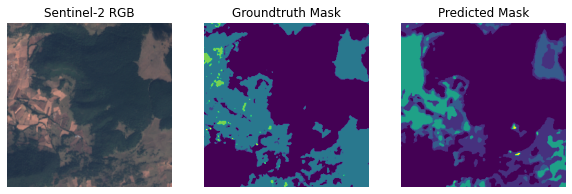

train_acc_segmentation,▁▅▅▆▇▇████
train_iou_segmentation,▁▄▅▆▆▇▇███
train_loss_segmentation,█▄▄▃▂▂▁▁▁▁
val_acc_segmentation,▁▄▅▇▇▇▇▇██
val_iou_segmentation,▁▄▄▆▆▆▇▇█▇
val_loss_segmentation,█▄▄▂▂▂▂▂▁▁
train_acc_segmentation,0.81635
train_iou_segmentation,0.46275
train_loss_segmentation,0.49332
val_acc_segmentation,0.83183
val_iou_segmentation,0.47158


Validation Loss: 0.9188: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]

train_iou is 0.2649, val_iou is 0.2688
train_acc is 0.6415, val_acc is 0.6476



Validation Loss: 0.8060: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3355, val_iou is 0.3263
train_acc is 0.7153, val_acc is 0.6883


Validation Loss: 0.6855: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3603, val_iou is 0.3595
train_acc is 0.7372, val_acc is 0.7459


Validation Loss: 0.6446: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3688, val_iou is 0.3822
train_acc is 0.7463, val_acc is 0.7637


Validation Loss: 0.6586: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]

train_iou is 0.3755, val_iou is 0.3652
train_acc is 0.7526, val_acc is 0.7541



Validation Loss: 0.6380: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


Saving Model...
train_iou is 0.3812, val_iou is 0.3784
train_acc is 0.7549, val_acc is 0.7613


Validation Loss: 0.5899: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]


Saving Model...
train_iou is 0.3895, val_iou is 0.3950
train_acc is 0.7606, val_acc is 0.7800


Validation Loss: 0.5966: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]

train_iou is 0.3885, val_iou is 0.4131
train_acc is 0.7610, val_acc is 0.7787



Validation Loss: 0.6109: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]

train_iou is 0.3989, val_iou is 0.3951
train_acc is 0.7677, val_acc is 0.7753



Validation Loss: 0.6111: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]


train_iou is 0.4052, val_iou is 0.4020
train_acc is 0.7731, val_acc is 0.7706
Finished Training


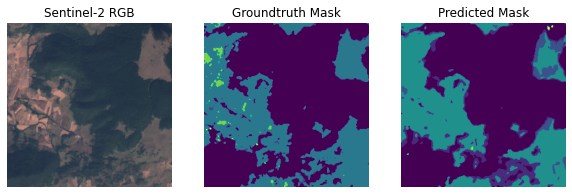

TypeError: ignored

In [ ]:
for filename in check_point_paths:
    # Update checkpoint name
    train_config.checkpoint_name = filename
    # Load Encoder from different pre-text architectures
    encoder = load_encoder_checkpoint_from_pretext_model(
        path_to_checkpoint=filename,
    )
    # patch_first_conv(encoder,13,default_in_channels=3)

    # freeze layers
    if train_config.frozen == True:
        for param in encoder.parameters():
          param.requires_grad = False

    model_name = filename.split("/")[-1].split(".")[0]
    model_dir = '/content/drive/My Drive/deep_learning_segmentation_checkpoints'
    model_path = os.path.join(model_dir,f'segmentation_{model_name}_eurosat13.ckpt')
    # make sure the directory path exists
    assert os.path.exists(model_dir)
    

    wandb.init(
        project="ssl-remote-sensing-segmentation-dfc-frozen",
        name=model_name,
        config=train_config.__dict__,
    )

    # Model setup
    if "bigan" in train_config.checkpoint_name.lower():
        model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    
    # train(model)
    train(model,train_config,train_loader,val_loader,loss_fn,device,model_path,wandb = wandb)
    
    # Initialise a UNet() model 
    if "bigan" in train_config.checkpoint_name.lower():
        bst_model = ResNetUNet(9,encoder = encoder, gan_encoder=True)
    else:
        bst_model = ResNetUNet(9, encoder = encoder, gan_encoder=False)
    # # Load pretrained weights
    bst_model.load_state_dict(torch.load(model_path))
    # # Move to device (GPU or CPU)
    bst_model.to(device)
    # visualize_result(171,bst_model)
    visualize_result(171,bst_model,valset,device,wandb = wandb,model_name = model_name)